# Sentence Embedding - Présentation générale

* Ce notebook présente différentes techniques de "Sentence Embeddings", permettant de générer des features à partir de phrases (ici des tweets)
* L'objectif est de pouvoir séparer les sentiments des tweets de façon automatique, via un T-SNE, qui permet une réduction des features en 2 dimensions
* C'est un notebook d'exemples afin de mieux comprendre la mise en oeuvre des techniques. Il n'est pas optimisé et doit être adapté à un nouveau contexte, en particulier sur les points suivants :
    * Le nettoyage des textes
    * les modèles BERT (model_type) idéalement pré-entraînés sur des données similaires au contexte (ici le modèle 'cardiffnlp/twitter-roberta-base-sentiment' surperforme le modèle de base car il a été pré-entraîné sur des tweets)
    * La taille des vecteurs (max_length)
    * Le batch_size
    * La perplexité du Tsne (perplexity à 30 par défaut)

# Préparation initiale dataset

## Récupération du dataset et filtres de données

In [13]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [14]:
data_T = pd.read_csv('nouveau_df_modifie.csv', sep=',')
print(data_T.shape)

(352, 3)


In [17]:
data_T.head()

,Tags,Concat,Tokens
0,",performance,,rust,,hashmap,",Faster HashMap for sequential keys Initially I...,"['Faster', 'HashMap', 'sequential', 'keys', 'I..."
1,",r,,dplyr,,tibble,",How to add a row to each group and assign valu...,"['group', 'assign', 'values', 'tibble', 'libra..."
2,",containers,,podman,",podman machine - Cannot connect to Podman on M...,"['podman', 'machine', 'connect', 'Podman', 'Ma..."
3,",reactjs,,typescript,,visual-studio-code,,esli...",VSCode prettier adds `value` to imports in Typ...,"['VSCode', 'prettier', 'adds', 'value', 'impor..."
4,",reactjs,,jestjs,","jest.mock() doesn't work inside tests, only ou...","['jestmock', 'work', 'inside', 'tests', 'outsi..."


In [19]:
l_cat = list(set(data_T['Tokens']))
y_cat_num = [(1-l_cat.index(data_T.iloc[i]['Tokens'])) for i in range(len(data_T))]

# Word2Vec

In [22]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

## Création du modèle Word2Vec

In [24]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = data_T['Tokens'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [25]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 7943
Word2Vec trained


In [28]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 7944


## Création de la matrice d'embedding

In [31]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (7944, 300)


## Création du modèle d'embedding

In [33]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

C:\Users\pierr\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 24, 300)             │       2,383,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 300)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,383,200 (9.09 MB)

 Trainable params: 2,383,200 (9.09 MB)

 Non-trainable params: 0 (0.00 B)

## Exécution du modèle

In [35]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


(352, 300)

In [37]:
import time
from sklearn import manifold,cluster,metrics,decomposition
from sklearn import cluster, metrics, manifold
import numpy as np
import time

def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat):
    # Limiter la taille de la figure
    fig = plt.figure(figsize=(10, 5))

    # Limiter les axes pour éviter une trop grande dispersion
    ax1 = fig.add_subplot(121)
    scatter1 = ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat_num, cmap='Set1', alpha=0.6)
    ax1.set_title('Tweets par catégories réelles')

    # Limiter la plage des axes pour éviter de trop grandes figures
    ax1.set_xlim(np.min(X_tsne[:, 0]) - 10, np.max(X_tsne[:, 0]) + 10)
    ax1.set_ylim(np.min(X_tsne[:, 1]) - 10, np.max(X_tsne[:, 1]) + 10)

    # Deuxième graphique
    ax2 = fig.add_subplot(122)
    scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1', alpha=0.6)
    ax2.set_title('Tweets par clusters')

    # Limiter également la plage des axes pour cette figure
    ax2.set_xlim(np.min(X_tsne[:, 0]) - 10, np.max(X_tsne[:, 0]) + 10)
    ax2.set_ylim(np.min(X_tsne[:, 1]) - 10, np.max(X_tsne[:, 1]) + 10)

    # Ajuster les marges et l'espacement entre les sous-graphiques
    plt.tight_layout()

    plt.show()

    print(f"ARI : {ARI}")

In [39]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.0 time :  31.0


C:\Users\pierr\anaconda3\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (351) found smaller than n_clusters (352). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


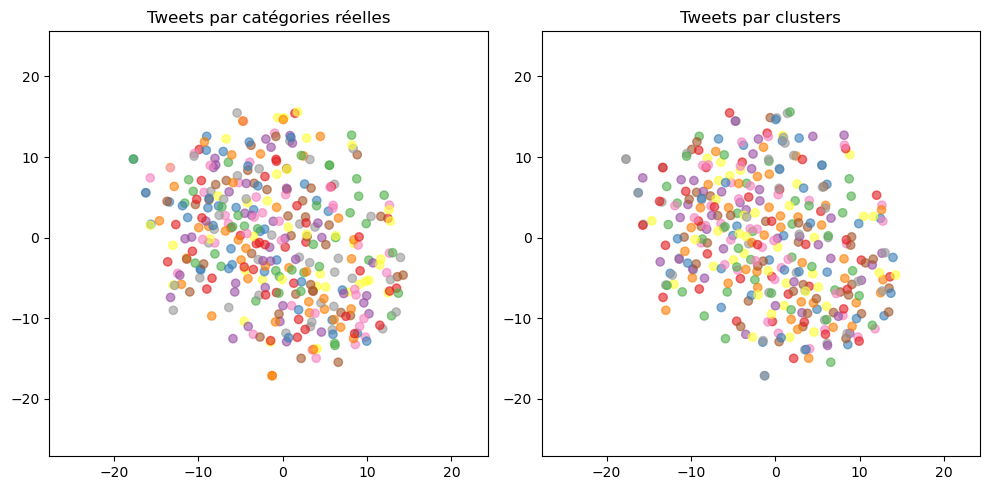

ARI : 0.0


In [41]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat)

# BERT

In [45]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

C:\Users\pierr\anaconda3\Lib\site-packages\transformers\deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


In [46]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.16.2
2.16.2
Num GPUs Available:  0
False


## Fonctions communes

In [51]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF'):
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()
    
    last_hidden_states_tot = []  # Liste pour stocker les résultats

    for step in range((len(sentences) + batch_size - 1) // batch_size):
        idx = step * batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx + batch_size], 
                                                                              bert_tokenizer, max_length)
        if mode == 'HF':  # Bert HuggingFace
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            last_hidden_states = outputs['last_hidden_state']

        elif mode == 'TFhub':  # Bert Tensorflow Hub
            text_preprocessed = {
                "input_word_ids": input_ids,
                "input_mask": attention_mask,
                "input_type_ids": token_type_ids
            }
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
        
        # Ajouter les résultats à la liste
        last_hidden_states_tot.append(last_hidden_states)

    # Concaténer tous les états cachés une fois la boucle terminée
    last_hidden_states_tot = np.concatenate(last_hidden_states_tot, axis=0)

    # Calculer la moyenne pour obtenir les features BERT
    features_bert = np.mean(last_hidden_states_tot, axis=1)
    
    time2 = np.round(time.time() - time1, 0)
    print("temps traitement : ", time2)
    
    return features_bert, last_hidden_states_tot


## BERT HuggingFace

### 'bert-base-uncased'

In [55]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['Concat'].to_list()


loading configuration file config.json from cache at C:\Users\pierr\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at C:\Users\pierr\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a6

Loaded 109,482,240 parameters in the TF 2.0 model.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on

In [56]:
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at C:\Users\pierr\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\pierr\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\vocab.t

temps traitement :  55.0


In [57]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  1.0 time :  35.0


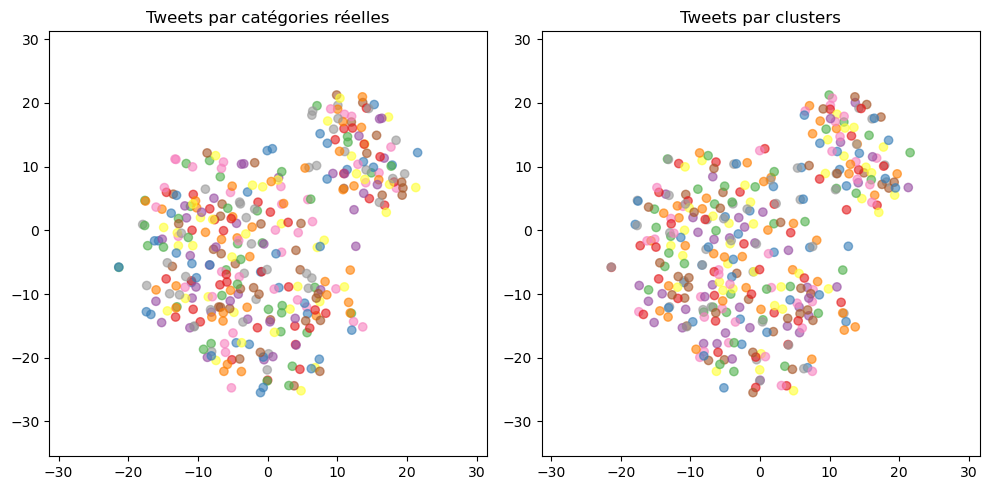

ARI : 1.0


In [371]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat)

### 'cardiffnlp/twitter-roberta-base-sentiment'
* Modèle pré-entraîné sur des tweets pour l'analyse de sentiment = particulièrement adapté au contexte

In [295]:
max_length = 64
batch_size = 10
model_type = 'cardiffnlp/twitter-roberta-base-sentiment'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['Concat'].to_list()

loading configuration file config.json from cache at C:\Users\pierr\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment\snapshots\daefdd1f6ae931839bce4d0f3db0a1a4265cd50f\config.json
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute

In [296]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at C:\Users\pierr\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment\snapshots\daefdd1f6ae931839bce4d0f3db0a1a4265cd50f\config.json
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads

temps traitement :  47.0
[[ 0.13839585 -0.38314533 -0.16519801 ... -0.66329896 -0.31267133
   0.09771717]
 [ 0.32634127 -0.6597377  -0.18609801 ... -1.1056122  -0.23869303
   0.20691852]
 [-0.00521425 -0.05073112 -0.04676371 ... -0.88077134 -0.2828729
   0.07309607]
 ...
 [-0.3438367  -0.7162495  -0.12957482 ... -1.4141611  -0.26111802
  -0.49527833]
 [-0.23233007 -0.48835874 -0.06600909 ... -1.4488842  -0.14034273
  -0.48509318]
 [ 0.41477364 -0.3983103  -0.32036212 ... -1.2448817  -0.28300226
   0.58654773]]


In [299]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  1.0 time :  28.0


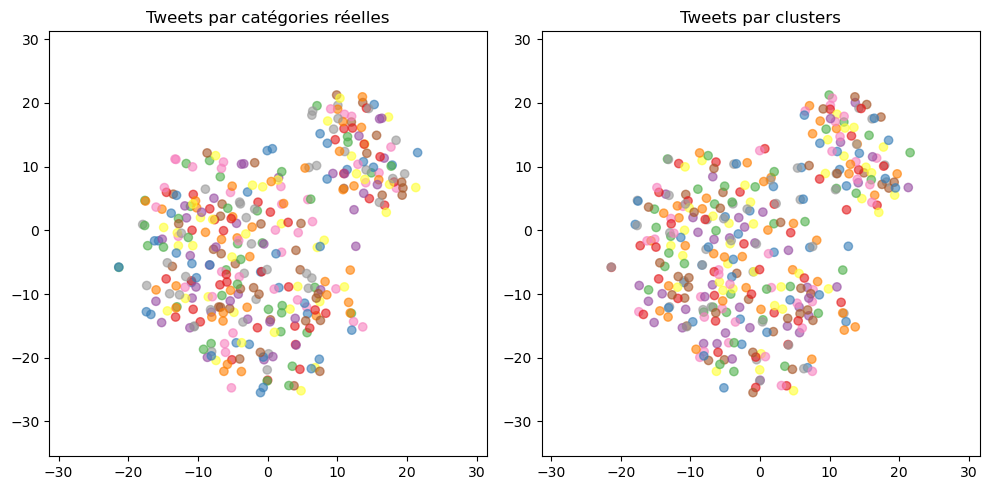

ARI : 1.0


In [373]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat)

## BERT hub Tensorflow

In [307]:

import tensorflow_hub as hub

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [309]:
sentences = data_T['Concat'].to_list()

In [311]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

loading configuration file config.json from cache at C:\Users\pierr\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\pierr\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\vocab.t

temps traitement :  37.0
[[-0.30141473 -0.12261996  0.23439194 ... -0.19622563 -0.11953659
   0.2668206 ]
 [-0.08250944 -0.19959682  0.3869301  ... -0.33393466 -0.04586275
   0.65699303]
 [-0.5388166  -0.1230351   0.60123354 ... -0.17025231  0.09647532
   0.26350662]
 ...
 [-0.19146883 -0.00523315  0.5258546  ... -0.28608915 -0.06819773
   0.19016264]
 [-0.2127563   0.08760404  0.42210916 ... -0.3082068  -0.15910096
   0.19444868]
 [-0.15934475 -0.07063874  0.10066021 ... -0.39268306 -0.2185045
   0.47152784]]


In [313]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  1.0 time :  29.0


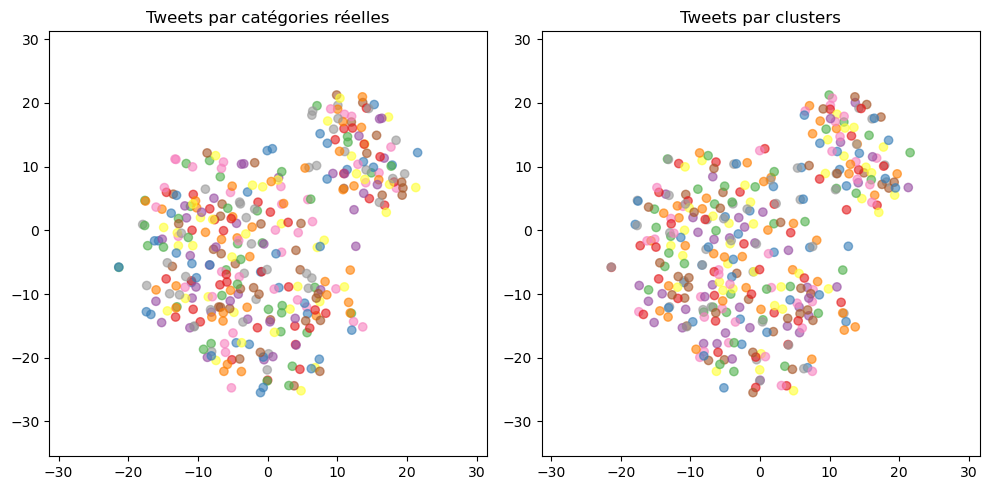

ARI : 1.0


In [375]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat)

# USE - Universal Sentence Encoder

In [327]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [329]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.16.2
2.16.2
Num GPUs Available:  0
False


In [331]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [343]:
def feature_USE_fct(sentences, b_size):
    batch_size = b_size
    time1 = time.time()

    features = []
    for step in range(len(sentences) // batch_size + 1):  # Assurez-vous de traiter tous les lots
        idx = step * batch_size
        if idx < len(sentences):
            feat = embed(sentences[idx:idx + batch_size])
            features.append(feat)

    features = np.concatenate(features, axis=0)  # Concaténer toutes les fonctionnalités
    time2 = np.round(time.time() - time1, 0)
    return features


In [345]:
batch_size = 10
sentences = data_T['Concat'].to_list()

In [347]:
features_USE = feature_USE_fct(sentences, batch_size)

In [349]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  1.0 time :  29.0


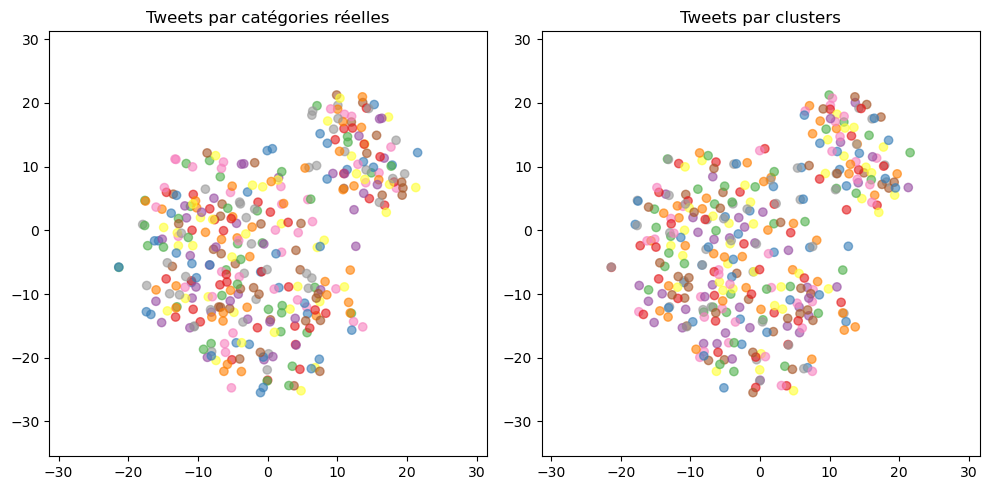

ARI : 1.0


In [377]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat)